(0.5065558603137313, (0.3636715903028532, 0.626151952228349))

(0.1983498907111068, (0.07744764691867956, 0.31350298707548263))

(0.4677215312937726, (-0.3435117847128395, 0.8792308382893501))

(-0.012613028214413239, (-0.33805111505237523, 0.3155192959736773))

(0.16202130099182538, (0.030888349369065763, 0.2876711200409068))

(0.3559991212192356, (0.2171160736938831, 0.48075534542974774))

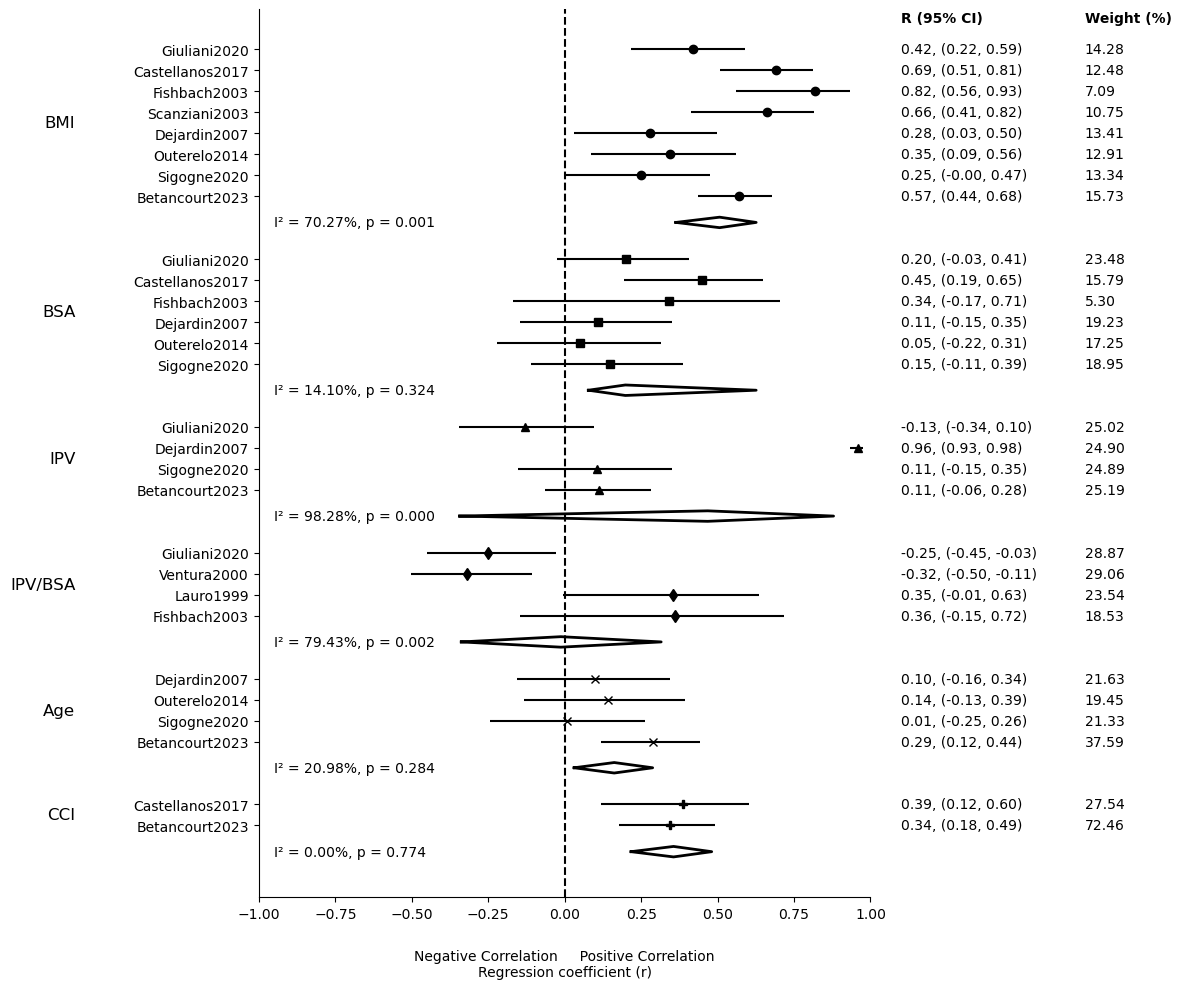

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data extraction

data = {
    'study_id': ['Giuliani2020', 'Castellanos2017', 'Ventura2000', 'Lauro1999', 'Fishbach2003',
                 'Scanziani2003', 'Dejardin2007', 'Outerelo2014', 'Sigogne2020', 'Rusthoven2005',
                 'Betancourt2023', 'Aranda2000'],

    'n': [77, 49, 81, 30, 17, 34, 61, 54, 60, 30, 124, 24],
    'r_bmi': [0.42, 0.69, np.nan, np.nan, 0.82, 0.66, 0.28, 0.346, 0.251, np.nan, 0.569, np.nan],
    'r_bsa': [0.2, 0.45, np.nan, np.nan, 0.34, np.nan, 0.11, 0.05, 0.148, np.nan, np.nan, np.nan],
    'r_ipv': [-0.13, np.nan, np.nan, np.nan, np.nan, np.nan, 0.96, np.nan, 0.107, np.nan, 0.113, np.nan],
    'r_ipv_bsa': [-0.25, np.nan, -0.319, 0.355, 0.36, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    'r_age':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.1, 0.141, 0.009, np.nan, 0.29, np.nan,],
    'r_cci':[np.nan, 0.387, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.344, np.nan,]
}

# Separate valid data

def extract_valid_data(data, r_key):
    valid_data = {'study_id': [], 'n': [], 'r': []}
    for i, r in enumerate(data[r_key]):
        if not np.isnan(r):
            valid_data['study_id'].append(data['study_id'][i])
            valid_data['n'].append(data['n'][i])
            valid_data['r'].append(r)
    return valid_data

def perform_meta_analysis(valid_data):
    valid_data['z'] = 0.5 * np.log((1 + np.array(valid_data['r'])) / (1 - np.array(valid_data['r'])))
    valid_data['var_z'] = 1 / (np.array(valid_data['n']) - 3)
    w = 1 / np.array(valid_data['var_z'])
    z_bar = np.sum(w * valid_data['z']) / np.sum(w)
    k = len(valid_data['z'])  
    Q = np.sum(w * (valid_data['z'] - z_bar)**2)
    # Calculating p-value for Q
    p_value_Q = 1 - stats.chi2.cdf(Q, k-1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_z']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['z']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)

    # Back Transformation to r Scale
    r_bar_RE = (np.exp(2 * z_bar_RE) - 1) / (np.exp(2 * z_bar_RE) + 1)
    ci_r_bar_RE = ((np.exp(2 * ci_z_bar_RE[0]) - 1) / (np.exp(2 * ci_z_bar_RE[0]) + 1),
                   (np.exp(2 * ci_z_bar_RE[1]) - 1) / (np.exp(2 * ci_z_bar_RE[1]) + 1))

    return r_bar_RE, ci_r_bar_RE, valid_data, weights_percent, I2, Q, p_value_Q

# Extracting valid data and performing meta-analyses
valid_data_bmi = extract_valid_data(data, 'r_bmi')
r_bar_RE_bmi, ci_r_bar_RE_bmi, valid_data_bmi, weights_percent_bmi, I2_bmi, Q_bmi, p_value_Q_bmi  = perform_meta_analysis(valid_data_bmi)
valid_data_bsa = extract_valid_data(data, 'r_bsa')
r_bar_RE_bsa, ci_r_bar_RE_bsa, valid_data_bsa, weights_percent_bsa, I2_bsa, Q_bsa, p_value_Q_bsa = perform_meta_analysis(valid_data_bsa)
valid_data_ipv = extract_valid_data(data, 'r_ipv')
r_bar_RE_ipv, ci_r_bar_RE_ipv, valid_data_ipv, weights_percent_ipv, I2_ipv, Q_ipv, p_value_Q_ipv = perform_meta_analysis(valid_data_ipv)
valid_data_ipv_bsa = extract_valid_data(data, 'r_ipv_bsa')
r_bar_RE_ipv_bsa, ci_r_bar_RE_ipv_bsa, valid_data_ipv_bsa, weights_percent_ipv_bsa, I2_ipv_bsa, Q_ipv_bsa, p_value_Q_ipv_bsa = perform_meta_analysis(valid_data_ipv_bsa)
valid_data_age = extract_valid_data(data, 'r_age')
r_bar_RE_age, ci_r_bar_RE_age, valid_data_age, weights_percent_age, I2_age, Q_age, p_value_Q_age = perform_meta_analysis(valid_data_age)
valid_data_cci = extract_valid_data(data, 'r_cci')
r_bar_RE_cci, ci_r_bar_RE_cci, valid_data_cci, weights_percent_cci, I2_cci, Q_cci, p_value_Q_cci = perform_meta_analysis(valid_data_cci)

# Extracting data for the plot
def extract_plot_data(valid_data):
    z_values = valid_data['z']
    z_se = np.sqrt(valid_data['var_z'])
    r_values = (np.exp(2 * np.array(z_values)) - 1) / (np.exp(2 * np.array(z_values)) + 1)
    ci_lower = (np.exp(2 * (z_values - 1.96 * z_se)) - 1) / (np.exp(2 * (z_values - 1.96 * z_se)) + 1)
    ci_upper = (np.exp(2 * (z_values + 1.96 * z_se)) - 1) / (np.exp(2 * (z_values + 1.96 * z_se)) + 1)
    return r_values, ci_lower, ci_upper

# Extracting plot data
r_values_bmi, ci_lower_bmi, ci_upper_bmi= extract_plot_data(valid_data_bmi)
r_values_bsa, ci_lower_bsa, ci_upper_bsa = extract_plot_data(valid_data_bsa)
r_values_ipv, ci_lower_ipv, ci_upper_ipv = extract_plot_data(valid_data_ipv)
r_values_ipv_bsa, ci_lower_ipv_bsa, ci_upper_ipv_bsa = extract_plot_data(valid_data_ipv_bsa)
r_values_age, ci_lower_age, ci_upper_age = extract_plot_data(valid_data_age)
r_values_cci, ci_lower_cci, ci_upper_cci = extract_plot_data(valid_data_cci)

# Results: Pooled correlation and 95% CI for BMI, BSA, IPV, IPV/BSA, Age
display((r_bar_RE_bmi, ci_r_bar_RE_bmi), 
        (r_bar_RE_bsa, ci_r_bar_RE_bsa), 
        (r_bar_RE_ipv, ci_r_bar_RE_ipv), 
        (r_bar_RE_ipv_bsa, ci_r_bar_RE_ipv_bsa), 
        (r_bar_RE_age, ci_r_bar_RE_age),
        (r_bar_RE_cci, ci_r_bar_RE_cci))

# Creating a combined forest plot with 2-row x-label
fig, ax = plt.subplots(figsize=(16, 10))

# Removing the top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plotting IPP-BMI data
ax.errorbar(r_values_bmi, np.arange(len(valid_data_bmi['study_id'])), xerr=[r_values_bmi - ci_lower_bmi, ci_upper_bmi - r_values_bmi], fmt='o', label='IPP-BMI Estimate', color='black')
x_bmi = [ci_r_bar_RE_bmi[0], 
         r_bar_RE_bmi, 
         ci_r_bar_RE_bmi[1], 
         r_bar_RE_bmi, 
         ci_r_bar_RE_bmi[0]]
y_bmi = [len(valid_data_bmi['study_id']) + 0.25, 
         len(valid_data_bmi['study_id']), 
         len(valid_data_bmi['study_id']) + 0.25, 
         len(valid_data_bmi['study_id']) + 0.5, 
         len(valid_data_bmi['study_id']) + 0.25]
ax.plot(x_bmi, y_bmi, 'k-', linewidth=2, label='95% CI of IPP-BMI Pooled Estimate')
# Adding text (weights) to the right
for i, (weight, r, ci_low, ci_high) in enumerate(zip(weights_percent_bmi, 
                                                     r_values_bmi, 
                                                     ci_lower_bmi, 
                                                     ci_upper_bmi)):
    ax.text(1.1, i, f"{r:.2f}, ({ci_low:.2f}, {ci_high:.2f})", va='center')
    ax.text(1.7, i, f"{weight:.2f}", va='center')
ax.text(-0.95, len(valid_data_bmi['study_id']) + 0.25, f"I² = {I2_bmi:.2f}%, p = {p_value_Q_bmi:.3f}", va='center', ha='left', fontsize=10)

# # Plotting IPP-BSA data
offset_bsa = len(valid_data_bmi['study_id']) + 2
ax.errorbar(r_values_bsa, np.arange(len(valid_data_bsa['study_id'])) + offset_bsa, xerr=[r_values_bsa - ci_lower_bsa, ci_upper_bsa - r_values_bsa], fmt='s', label='IPP-BSA Estimate', color='black')
x_bsa = [ci_r_bar_RE_bsa[0], 
         r_bar_RE_bsa, 
         ci_r_bar_RE_bmi[1], 
         r_bar_RE_bsa, 
         ci_r_bar_RE_bsa[0]]
y_bsa = [offset_bsa + len(valid_data_bsa['study_id']) + 0.25, 
         offset_bsa + len(valid_data_bsa['study_id']), 
         offset_bsa + len(valid_data_bsa['study_id']) + 0.25, 
         offset_bsa + len(valid_data_bsa['study_id']) + 0.5, 
         offset_bsa + len(valid_data_bsa['study_id']) + 0.25]
ax.plot(x_bsa, y_bsa, 'k-', linewidth=2, label='95% CI of IPP-BSA Pooled Estimate')
# Adding text (weights) to the right
for i, (weight, r, ci_low, ci_high) in enumerate(zip(weights_percent_bsa, 
                                                     r_values_bsa, 
                                                     ci_lower_bsa, 
                                                     ci_upper_bsa)):
    ax.text(1.1, offset_bsa + i, f"{r:.2f}, ({ci_low:.2f}, {ci_high:.2f})", va='center')
    ax.text(1.7, offset_bsa + i, f"{weight:.2f}", va='center')
ax.text(-0.95, offset_bsa + len(valid_data_bsa['study_id']) + 0.25, f"I² = {I2_bsa:.2f}%, p = {p_value_Q_bsa:.3f}", va='center', ha='left', fontsize=10)

# Plotting IPP-IPV data
offset_ipv = offset_bsa + len(valid_data_bsa['study_id']) + 2
ax.errorbar(r_values_ipv, np.arange(len(valid_data_ipv['study_id'])) + offset_ipv, xerr=[r_values_ipv - ci_lower_ipv, ci_upper_ipv - r_values_ipv], fmt='^', label='IPP-IPV Estimate', color='black')
x_ipv = [ci_r_bar_RE_ipv[0], 
         r_bar_RE_ipv, 
         ci_r_bar_RE_ipv[1], 
         r_bar_RE_ipv, 
         ci_r_bar_RE_ipv[0]]
y_ipv = [offset_ipv + len(valid_data_ipv['study_id']) + 0.25, 
         offset_ipv + len(valid_data_ipv['study_id']), 
         offset_ipv + len(valid_data_ipv['study_id']) + 0.25, 
         offset_ipv + len(valid_data_ipv['study_id']) + 0.5, 
         offset_ipv + len(valid_data_ipv['study_id']) + 0.25]
ax.plot(x_ipv, y_ipv, 'k-', linewidth=2, label='95% CI of IPP-IPV Pooled Estimate')
# Adding text (weights) to the right
for i, (weight, r, ci_low, ci_high) in enumerate(zip(weights_percent_ipv, 
                                                     r_values_ipv, 
                                                     ci_lower_ipv, 
                                                     ci_upper_ipv)):
    ax.text(1.1, offset_ipv + i, f"{r:.2f}, ({ci_low:.2f}, {ci_high:.2f})", va='center')
    ax.text(1.7, offset_ipv + i, f"{weight:.2f}", va='center')
ax.text(-0.95, offset_ipv + len(valid_data_ipv['study_id']) + 0.25, f"I² = {I2_ipv:.2f}%, p = {p_value_Q_ipv:.3f}", va='center', ha='left', fontsize=10)

# Plotting IPV/BSA data
offset_ipv_bsa = offset_ipv + len(valid_data_ipv['study_id']) + 2
ax.errorbar(r_values_ipv_bsa, np.arange(len(valid_data_ipv_bsa['study_id'])) + offset_ipv_bsa, xerr=[r_values_ipv_bsa - ci_lower_ipv_bsa, ci_upper_ipv_bsa - r_values_ipv_bsa], fmt='d', label='IPV/BSA Estimate', color='black')
x_ipv_bsa = [ci_r_bar_RE_ipv_bsa[0], 
         r_bar_RE_ipv_bsa, 
         ci_r_bar_RE_ipv_bsa[1], 
         r_bar_RE_ipv_bsa, 
         ci_r_bar_RE_ipv_bsa[0]]
y_ipv_bsa = [offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']) + 0.25, 
         offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']), 
         offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']) + 0.25, 
         offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']) + 0.5, 
         offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']) + 0.25]
ax.plot(x_ipv_bsa, y_ipv_bsa, 'k-', linewidth=2, label='95% CI of IPV/BSA Pooled Estimate')
# Adding text (weights) to the right
for i, (weight, r, ci_low, ci_high) in enumerate(zip(weights_percent_ipv_bsa, 
                                                     r_values_ipv_bsa, 
                                                     ci_lower_ipv_bsa, 
                                                     ci_upper_ipv_bsa)):
    ax.text(1.1, offset_ipv_bsa + i, f"{r:.2f}, ({ci_low:.2f}, {ci_high:.2f})", va='center')
    ax.text(1.7, offset_ipv_bsa + i, f"{weight:.2f}", va='center')
ax.text(-0.95, offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']) + 0.25, f"I² = {I2_ipv_bsa:.2f}%, p = {p_value_Q_ipv_bsa:.3f}", va='center', ha='left', fontsize=10)

# Plotting Age data
offset_age = offset_ipv_bsa + len(valid_data_ipv_bsa['study_id']) + 2
ax.errorbar(r_values_age, np.arange(len(valid_data_age['study_id'])) + offset_age, xerr=[r_values_age - ci_lower_age, ci_upper_age - r_values_age], fmt='x', label='Age Estimate', color='black')
x_age = [ci_r_bar_RE_age[0], 
         r_bar_RE_age, 
         ci_r_bar_RE_age[1], 
         r_bar_RE_age, 
         ci_r_bar_RE_age[0]]
y_age = [offset_age + len(valid_data_age['study_id']) + 0.25, 
         offset_age + len(valid_data_age['study_id']), 
         offset_age + len(valid_data_age['study_id']) + 0.25, 
         offset_age + len(valid_data_age['study_id']) + 0.5, 
         offset_age + len(valid_data_age['study_id']) + 0.25]
ax.plot(x_age, y_age, 'k-', linewidth=2, label='95% CI of Age Pooled Estimate')
# Adding text (weights) to the right
for i, (weight, r, ci_low, ci_high) in enumerate(zip(weights_percent_age, 
                                                     r_values_age, 
                                                     ci_lower_age, 
                                                     ci_upper_age)):
    ax.text(1.1, offset_age + i, f"{r:.2f}, ({ci_low:.2f}, {ci_high:.2f})", va='center')
    ax.text(1.7, offset_age + i, f"{weight:.2f}", va='center')
ax.text(-0.95, offset_age + len(valid_data_age['study_id']) + 0.25, f"I² = {I2_age:.2f}%, p = {p_value_Q_age:.3f}", va='center', ha='left', fontsize=10)

# Plotting CCI data
offset_cci = offset_age + len(valid_data_age['study_id']) + 2
ax.errorbar(r_values_cci, np.arange(len(valid_data_cci['study_id'])) + offset_cci, xerr=[r_values_cci - ci_lower_cci, ci_upper_cci - r_values_cci], fmt='P', label='CCI Estimate', color='black')
x_cci = [ci_r_bar_RE_cci[0], 
         r_bar_RE_cci, 
         ci_r_bar_RE_cci[1], 
         r_bar_RE_cci, 
         ci_r_bar_RE_cci[0]]
y_cci = [offset_cci + len(valid_data_cci['study_id']) + 0.25, 
         offset_cci + len(valid_data_cci['study_id']), 
         offset_cci + len(valid_data_cci['study_id']) + 0.25, 
         offset_cci + len(valid_data_cci['study_id']) + 0.5, 
         offset_cci + len(valid_data_cci['study_id']) + 0.25]
ax.plot(x_cci, y_cci, 'k-', linewidth=2, label='95% CI of CCI Pooled Estimate')
# Adding text (weights) to the right
for i, (weight, r, ci_low, ci_high) in enumerate(zip(weights_percent_cci, 
                                                     r_values_cci, 
                                                     ci_lower_cci, 
                                                     ci_upper_cci)):
    ax.text(1.1, offset_cci + i, f"{r:.2f}, ({ci_low:.2f}, {ci_high:.2f})", va='center')
    ax.text(1.7, offset_cci + i, f"{weight:.2f}", va='center')
ax.text(-0.95, offset_cci + len(valid_data_cci['study_id']) + 0.25, f"I² = {I2_cci:.2f}%, p = {p_value_Q_cci:.3f}", va='center', ha='left', fontsize=10)

# Annotations and labels
all_study_ids = valid_data_bmi['study_id'] + valid_data_bsa['study_id'] + valid_data_ipv['study_id'] + valid_data_ipv_bsa['study_id'] + valid_data_cci['study_id']
ax.set_yticks(list(np.arange(len(valid_data_bmi['study_id']))) + 
              list(np.arange(len(valid_data_bsa['study_id'])) + offset_bsa) + 
              list(np.arange(len(valid_data_ipv['study_id'])) + offset_ipv) +
              list(np.arange(len(valid_data_ipv_bsa['study_id'])) + offset_ipv_bsa) +
              list(np.arange(len(valid_data_age['study_id'])) + offset_age) +
              list(np.arange(len(valid_data_cci['study_id'])) + offset_cci))
ax.text(-1.6, np.mean(np.arange(len(valid_data_bmi['study_id']))), 'BMI', fontsize=12, va='center', ha='right')
ax.text(-1.6, np.mean(np.arange(len(valid_data_bsa['study_id'])) + offset_bsa), 'BSA', fontsize=12, va='center', ha='right')
ax.text(-1.6, np.mean(np.arange(len(valid_data_ipv['study_id'])) + offset_ipv), 'IPV', fontsize=12, va='center', ha='right')
ax.text(-1.6, np.mean(np.arange(len(valid_data_ipv_bsa['study_id'])) + offset_ipv_bsa), 'IPV/BSA', fontsize=12, va='center', ha='right')
ax.text(-1.6, np.mean(np.arange(len(valid_data_age['study_id'])) + offset_age), 'Age', fontsize=12, va='center', ha='right')
ax.text(-1.6, np.mean(np.arange(len(valid_data_cci['study_id'])) + offset_cci), 'CCI', fontsize=12, va='center', ha='right')
ax.text(1.1, -1.5, "R (95% CI)", va='center', ha='left', fontsize=10, fontweight='bold')
ax.text(1.7, -1.5, "Weight (%)", va='center', ha='left', fontsize=10, fontweight='bold')
ax.set_yticklabels(valid_data_bmi['study_id'] + valid_data_bsa['study_id'] + valid_data_ipv['study_id'] + valid_data_ipv_bsa['study_id'] + valid_data_age['study_id'] + valid_data_cci['study_id'])
ax.set_xlabel('Negative Correlation     Positive Correlation\nRegression coefficient (r)', labelpad=20)
ax.set_xlim([-1, 1])  # Setting x-axis limits to make it symmetrical

# Additional annotations and modifications
plt.axvline(x=0, color='black', linestyle='--')  # Add a vertical line at r = 0

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to have the first study on top
plt.tight_layout()
plt.show()